<h3><strong>Import Libraries</strong></h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Change Pandas Display Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  

<h3><strong>Read and Verify CSV</strong></h3>

In [4]:
# Read CSV
df = pd.read_csv('battles.csv')

# Print first five lines of CSV
print(df.head())

   Unnamed: 0                 battleTime    arena.id  gameMode.id  average.startingTrophies  winner.tag  winner.startingTrophies  winner.trophyChange  winner.crowns  winner.kingTowerHitPoints winner.princessTowersHitPoints winner.clan.tag  winner.clan.badgeId   loser.tag  loser.startingTrophies  loser.trophyChange  loser.crowns  loser.kingTowerHitPoints loser.clan.tag  loser.clan.badgeId loser.princessTowersHitPoints  tournamentTag  winner.card1.id  winner.card1.level  winner.card2.id  winner.card2.level  winner.card3.id  winner.card3.level  winner.card4.id  winner.card4.level  winner.card5.id  winner.card5.level  winner.card6.id  winner.card6.level  winner.card7.id  winner.card7.level  winner.card8.id  winner.card8.level                                  winner.cards.list  winner.totalcard.level  winner.troop.count  winner.structure.count  winner.spell.count  winner.common.count  winner.rare.count  winner.epic.count  winner.legendary.count  winner.elixir.average  loser.card1.id  \
0   

<h3><strong>Data Cleaning & Initial Inspection</strong></h3>

In [4]:
# Shape of Dataframe
print(df.shape)

(16795959, 74)


In [4]:
# All Columns in Dataframe
cols = df.columns.tolist()
print(cols)

['Unnamed: 0', 'battleTime', 'arena.id', 'gameMode.id', 'average.startingTrophies', 'winner.tag', 'winner.startingTrophies', 'winner.trophyChange', 'winner.crowns', 'winner.kingTowerHitPoints', 'winner.princessTowersHitPoints', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.startingTrophies', 'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints', 'loser.clan.tag', 'loser.clan.badgeId', 'loser.princessTowersHitPoints', 'tournamentTag', 'winner.card1.id', 'winner.card1.level', 'winner.card2.id', 'winner.card2.level', 'winner.card3.id', 'winner.card3.level', 'winner.card4.id', 'winner.card4.level', 'winner.card5.id', 'winner.card5.level', 'winner.card6.id', 'winner.card6.level', 'winner.card7.id', 'winner.card7.level', 'winner.card8.id', 'winner.card8.level', 'winner.cards.list', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count',

In [5]:
# Print Numerical Columns
numerical_cols = df.select_dtypes(include=np.number).columns
print(numerical_cols)

Index(['Unnamed: 0', 'arena.id', 'gameMode.id', 'average.startingTrophies', 'winner.startingTrophies', 'winner.trophyChange', 'winner.crowns', 'winner.kingTowerHitPoints', 'winner.clan.badgeId', 'loser.startingTrophies', 'loser.trophyChange', 'loser.crowns', 'loser.kingTowerHitPoints', 'loser.clan.badgeId', 'tournamentTag', 'winner.card1.id', 'winner.card1.level', 'winner.card2.id', 'winner.card2.level', 'winner.card3.id', 'winner.card3.level', 'winner.card4.id', 'winner.card4.level', 'winner.card5.id', 'winner.card5.level', 'winner.card6.id', 'winner.card6.level', 'winner.card7.id', 'winner.card7.level', 'winner.card8.id', 'winner.card8.level', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 'winner.elixir.average', 'loser.card1.id', 'loser.card1.level', 'loser.card2.id', 'loser.card2.level', 'loser.card3.id', 'loser.card3.level',
       'loser.car

In [7]:
# Print Data Types of Each Column
print(df.dtypes)

Unnamed: 0                          int64
battleTime                         object
arena.id                          float64
gameMode.id                       float64
average.startingTrophies          float64
winner.tag                         object
winner.startingTrophies           float64
winner.trophyChange               float64
winner.crowns                     float64
winner.kingTowerHitPoints         float64
winner.princessTowersHitPoints     object
winner.clan.tag                    object
winner.clan.badgeId               float64
loser.tag                          object
loser.startingTrophies            float64
loser.trophyChange                float64
loser.crowns                      float64
loser.kingTowerHitPoints          float64
loser.clan.tag                     object
loser.clan.badgeId                float64
loser.princessTowersHitPoints      object
tournamentTag                     float64
winner.card1.id                     int64
winner.card1.level                

In [19]:
# Null Values
print(df.isnull().sum())

Unnamed: 0                               0
battleTime                               0
arena.id                                 0
gameMode.id                              0
average.startingTrophies                 0
winner.tag                               0
winner.startingTrophies                  0
winner.trophyChange                      0
winner.crowns                            0
winner.kingTowerHitPoints                0
winner.princessTowersHitPoints      358362
winner.clan.tag                     702282
winner.clan.badgeId                 702282
loser.tag                                0
loser.startingTrophies                   0
loser.trophyChange                       0
loser.crowns                             0
loser.kingTowerHitPoints           5034320
loser.clan.tag                      937645
loser.clan.badgeId                  937645
loser.princessTowersHitPoints      9164173
tournamentTag                     16795959
winner.card1.id                          0
winner.card

In [8]:
# Print Number of Unique Values
print(df.nunique())

Unnamed: 0                        16795959
battleTime                         1336774
arena.id                                15
gameMode.id                              4
average.startingTrophies             14909
winner.tag                         5668828
winner.startingTrophies               7713
winner.trophyChange                     58
winner.crowns                            3
winner.kingTowerHitPoints             5890
winner.princessTowersHitPoints     3976333
winner.clan.tag                    1000273
winner.clan.badgeId                    180
loser.tag                          5972117
loser.startingTrophies                7706
loser.trophyChange                      58
loser.crowns                             3
loser.kingTowerHitPoints              5877
loser.clan.tag                     1049244
loser.clan.badgeId                     180
loser.princessTowersHitPoints         3668
tournamentTag                            0
winner.card1.id                        102
winner.card

<h5>Handling Null Values & Dropping Uninfluential Columns</h5>

In [5]:
# Dropping Columns (Columns with not mutch meaning/influence)
df = df.drop(columns=['Unnamed: 0', 'winner.tag', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.clan.tag', 'loser.clan.badgeId', 'tournamentTag' ])

In [6]:
# Resolving Null Values to 0
df['winner.princessTowersHitPoints'] = df['winner.princessTowersHitPoints'].fillna(0)
df['loser.kingTowerHitPoints'] = df['loser.kingTowerHitPoints'].fillna(0)
df['loser.princessTowersHitPoints'] = df['loser.princessTowersHitPoints'].fillna(0)

In [ ]:
# Reason we are able to resolve null values to 0

# Only appears when loser crowns is 2 which means that both winner and loser princess towers are destroyed (0 hitpoints)
print('Winner Princess Tower Hit Points to Loser Crowns:')
print(df.groupby(df['winner.princessTowersHitPoints'].isna())['loser.crowns'].describe())

# Null values appear when winner crowns is 3, which means that the king tower was destroyed (0 hit points)
print('\nLoser King Tower Hit Points to Winner Crowns:')
print(df.groupby(df['loser.kingTowerHitPoints'].isna())['winner.crowns'].describe())

# # Null values appear only when both princess towers are destroyed (0 hit points)
print('\nLoser Princess Tower Hit Points to Winner Crowns:')
print(df.groupby(df['loser.princessTowersHitPoints'].isna())['winner.crowns'].describe())

Winner Princess Tower Hit Points to Loser Crowns:
                                     count      mean       std  min  25%  50%  75%  max
winner.princessTowersHitPoints                                                         
False                           16437597.0  0.298905  0.457778  0.0  0.0  0.0  1.0  1.0
True                              358362.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0
Loser King Tower Hit Points to Winner Crowns:
                               count      mean       std  min  25%  50%  75%  max
loser.kingTowerHitPoints                                                         
False                     11761639.0  1.351129  0.477323  1.0  1.0  1.0  2.0  2.0
True                       5034320.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
Loser Princess Tower Hit Points to Winner Crowns:
                                   count      mean       std  min  25%  50%  75%  max
loser.princessTowersHitPoints                                                        
Fa

In [7]:
# Check for null values again
print(df.isnull().sum())

battleTime                        0
arena.id                          0
gameMode.id                       0
average.startingTrophies          0
winner.startingTrophies           0
winner.trophyChange               0
winner.crowns                     0
winner.kingTowerHitPoints         0
winner.princessTowersHitPoints    0
loser.startingTrophies            0
loser.trophyChange                0
loser.crowns                      0
loser.kingTowerHitPoints          0
loser.princessTowersHitPoints     0
winner.card1.id                   0
winner.card1.level                0
winner.card2.id                   0
winner.card2.level                0
winner.card3.id                   0
winner.card3.level                0
winner.card4.id                   0
winner.card4.level                0
winner.card5.id                   0
winner.card5.level                0
winner.card6.id                   0
winner.card6.level                0
winner.card7.id                   0
winner.card7.level          

<h3><strong>Exploratory Data Analysis</strong></h3>

In [18]:
# Summary Statistics
print(df.describe())

           arena.id   gameMode.id  average.startingTrophies  winner.startingTrophies  winner.trophyChange  winner.crowns  winner.kingTowerHitPoints  loser.startingTrophies  loser.trophyChange  loser.crowns  loser.kingTowerHitPoints  winner.card1.id  winner.card1.level  winner.card2.id  winner.card2.level  winner.card3.id  winner.card3.level  winner.card4.id  winner.card4.level  winner.card5.id  winner.card5.level  winner.card6.id  winner.card6.level  winner.card7.id  winner.card7.level  winner.card8.id  winner.card8.level  winner.totalcard.level  winner.troop.count  winner.structure.count  winner.spell.count  winner.common.count  winner.rare.count  winner.epic.count  winner.legendary.count  winner.elixir.average  loser.card1.id  loser.card1.level  loser.card2.id  loser.card2.level  loser.card3.id  loser.card3.level  loser.card4.id  loser.card4.level  loser.card5.id  loser.card5.level  loser.card6.id  loser.card6.level  loser.card7.id  loser.card7.level  loser.card8.id  \
count  1.67959

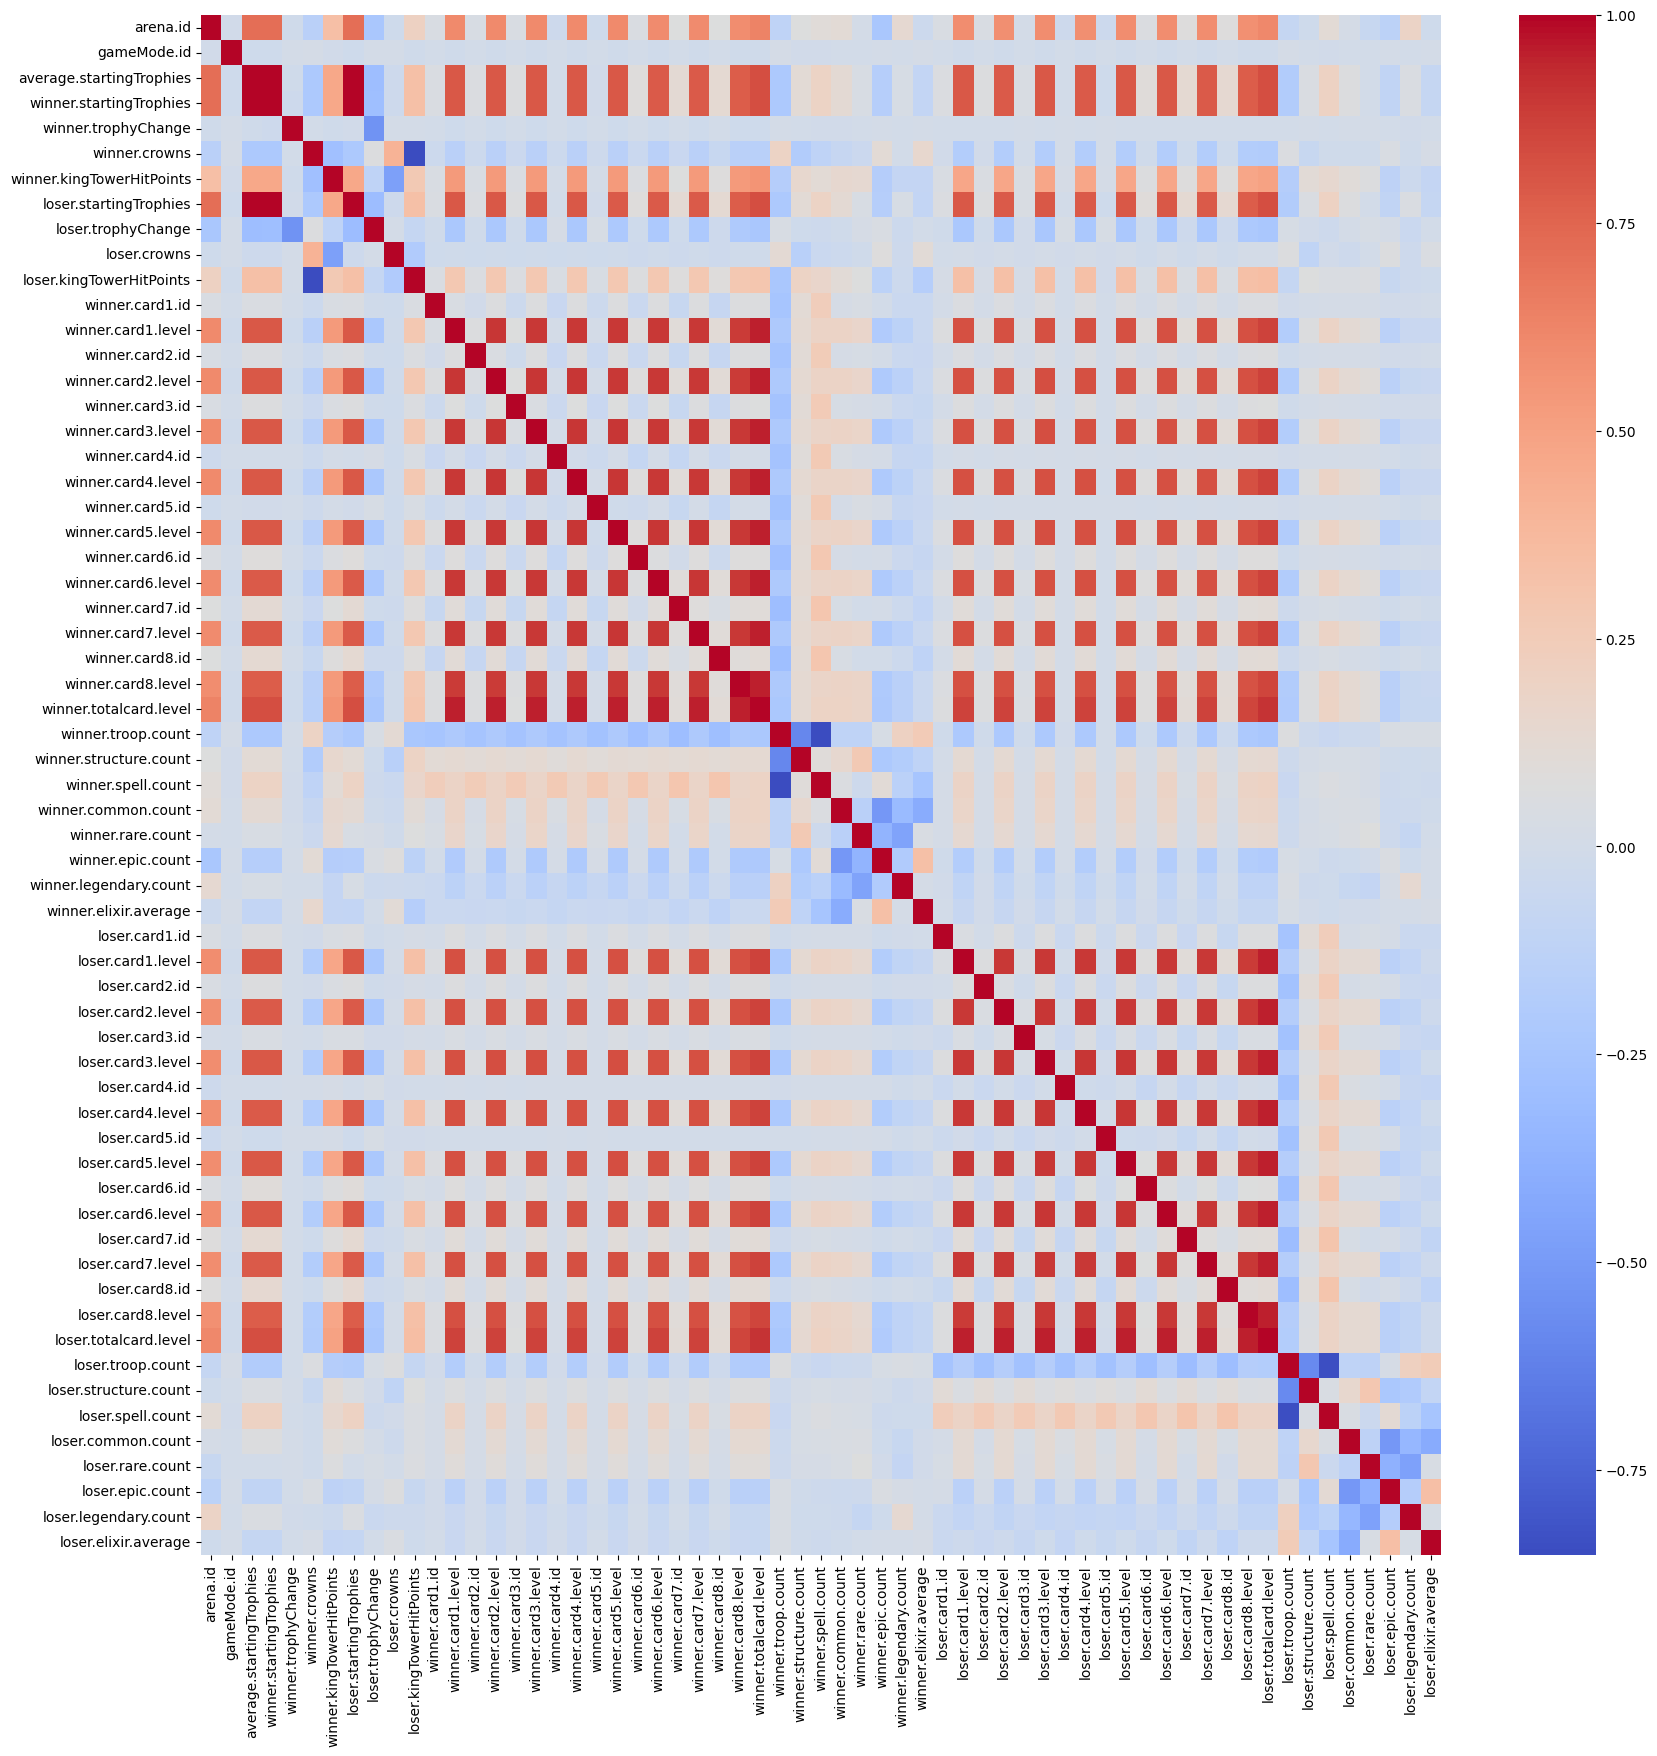

In [ ]:
# Correlation Heatmap (How much does one variable affect the other)
plt.figure(figsize=(20, 20))
co_mtx = df.corr(numeric_only=True)
sns.heatmap(co_mtx, cmap='coolwarm', fmt='.2f', annot=True)
plt.show()

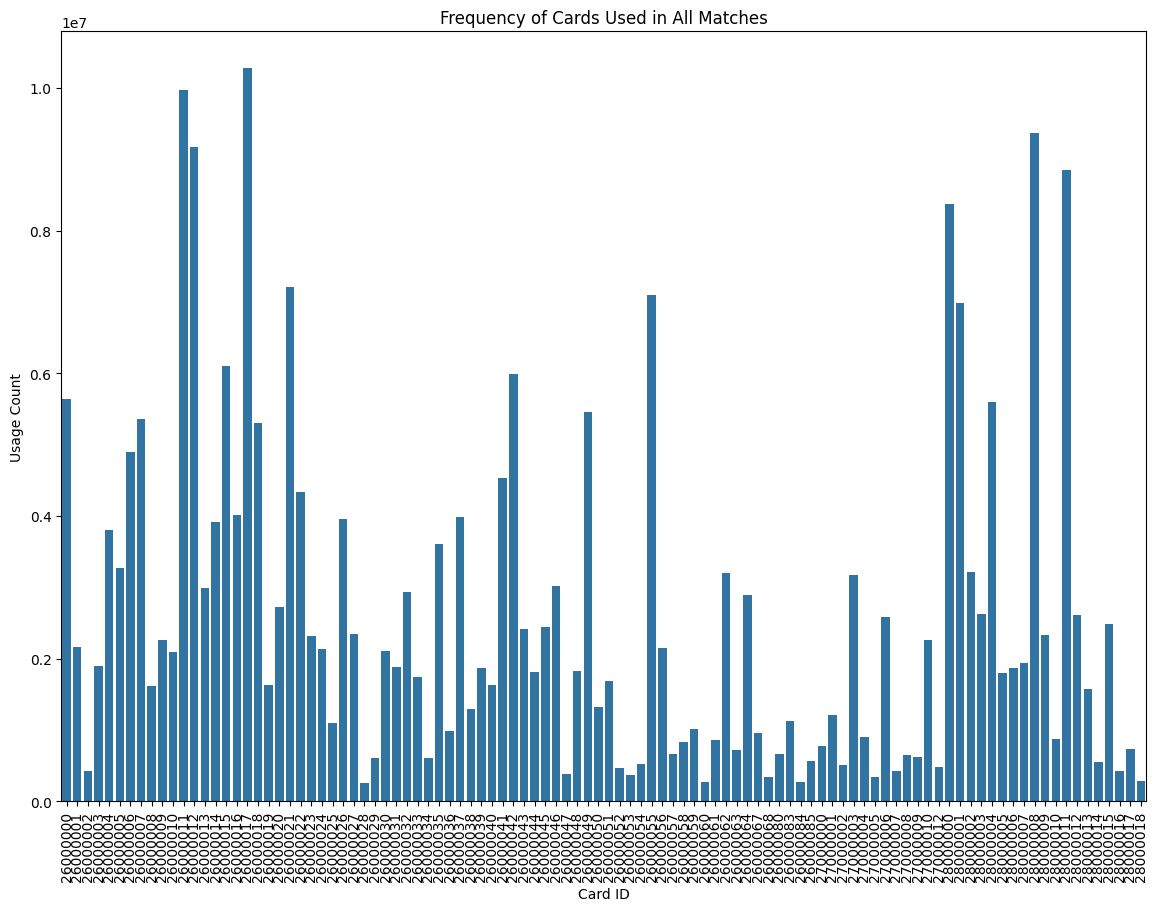

In [30]:
# Bar Plot of Cards used the most
card_cols = [
    'winner.card1.id', 'winner.card2.id', 'winner.card3.id', 'winner.card4.id',
    'winner.card5.id', 'winner.card6.id', 'winner.card7.id', 'winner.card8.id',
    'loser.card1.id', 'loser.card2.id', 'loser.card3.id', 'loser.card4.id',
    'loser.card5.id', 'loser.card6.id', 'loser.card7.id', 'loser.card8.id'
]

all_cards = df[card_cols].values.flatten()
card_counts = pd.Series(all_cards).value_counts()

plt.figure(figsize=(14, 10))
sns.barplot(x=card_counts.index, y=card_counts.values)
plt.title("Frequency of Cards Used in All Matches")
plt.xlabel("Card ID")
plt.ylabel("Usage Count")
plt.xticks(rotation=90)
plt.show()


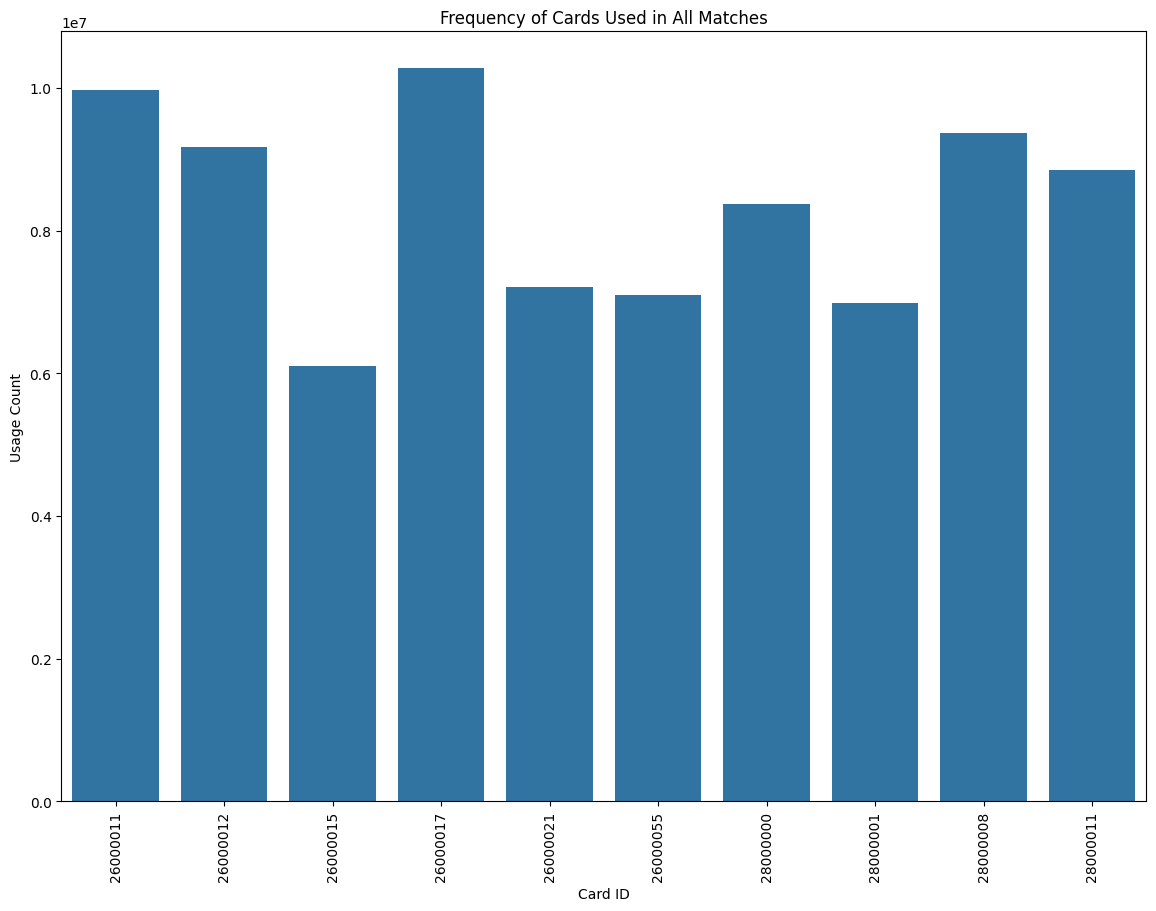

In [20]:
# Show the ten most used cards
top10 = card_counts.head(10)

plt.figure(figsize=(14, 10))
sns.barplot(x=top10.index, y=top10.values)
plt.title("Frequency of Cards Used in All Matches")
plt.xlabel("Card ID")
plt.ylabel("Usage Count")
plt.xticks(rotation=90)
plt.show()

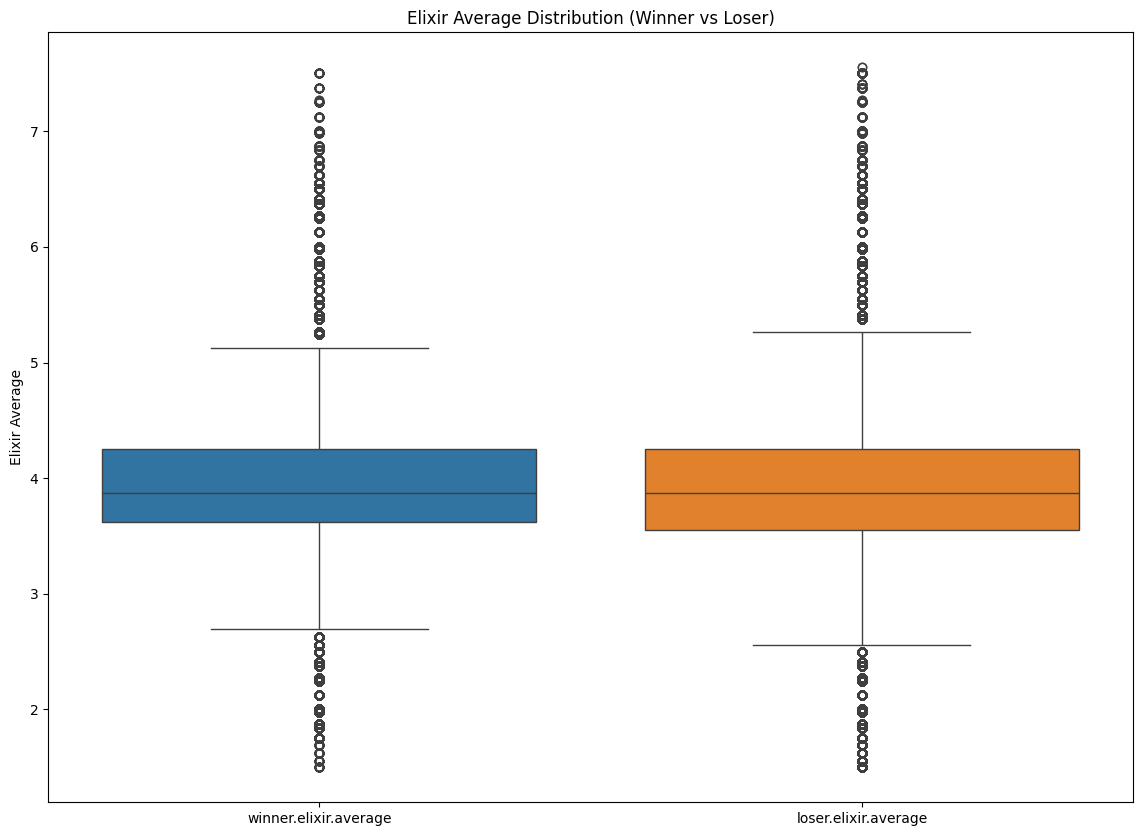

In [31]:
# Histogram of Winner Elixir Average vs Loser Elixir Average
plt.figure(figsize=(14, 10))
sns.boxplot(data=df[['winner.elixir.average', 'loser.elixir.average']])
plt.title("Elixir Average Distribution (Winner vs Loser)")
plt.ylabel("Elixir Average")
plt.show()

# Shows that elixir average alone doesn't determine match outcomes

<h3><strong>Data Prep for Model Building</strong></h3>

<h5>Creating a new dataframe with winning and losing cards in different rows and if the deck won</h5>

<h5>Creating a new dataframe which includes winning and losing cards from each match on the same row and which deck won</h5>

<h3><strong>Model Buidling</strong></h3>

<h5>Predicting overall win rate of one deck</h5>

<h5>Predicting overall win rate of deck A vs deck B</h5>